# ***Skin Cancer Classification***
# ***Applied Machine Learning W207 Final Project, Fall 2022***






# ***A. Importing the Libraries***

In [ ]:
!pip install fastai
!pip install imgaug


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from imutils import rotate as rotate
from itertools import product
import PIL
from PIL import Image
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon


from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import cv2 as cv
import skimage.io as skio

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [ ]:
tf.__version__

'2.9.2'

In [ ]:
! find /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input -maxdepth 1 -name "*.tif" -exec rm -rf {} \;


find: ‘/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input’: No such file or directory


# *File Processing* 




 1. ***Downloading Image Files from Kaggle***

In [ ]:

!kaggle datasets download -d andrewmvd/isic-2019 --force

100% 9.10G/9.10G [06:45<00:00, 28.3MB/s]
100% 9.10G/9.10G [06:45<00:00, 24.1MB/s]


2. ***Unzipping the Downaloaded Zip Files***

In [ ]:
#!rm -rf /content/*
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065358.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065359.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065360.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065361.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065362.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065366.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065367.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065368.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065370.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065371.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065372.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019

# ***Data Validation and Spot Checks***

***1. Train Files Count***

In [ ]:
!ls -ltr /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ |wc -l

25334


***2. Validating record count of ISIC_2019_Training_Metadata.csv with train file count***

In [ ]:
!wc -l ISIC_2019_Training_Metadata.csv
!wc -l ISIC_2019_Training_GroundTruth.csv

25332 ISIC_2019_Training_Metadata.csv
25332 ISIC_2019_Training_GroundTruth.csv


3. ***Explore file structure of ISIC_2019_Training_GroundTruth.csv***

In [ ]:
!head ISIC_2019_Training_GroundTruth.csv

image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Explore file structure of ISIC_2019_Training_Metadata.csv***

In [ ]:
!head ISIC_2019_Training_Metadata.csv

image,age_approx,anatom_site_general,lesion_id,sex
ISIC_0000000,55,anterior torso,,female
ISIC_0000001,30,anterior torso,,female
ISIC_0000002,60,upper extremity,,female
ISIC_0000003,30,upper extremity,,male
ISIC_0000004,80,posterior torso,,male
ISIC_0000006,25,posterior torso,,female
ISIC_0000007,25,posterior torso,,female
ISIC_0000008,30,anterior torso,,female
ISIC_0000009,30,anterior torso,,female


# ***Defining Parameters***

In [ ]:
CONTRAST_FACTOR = 3
DELTA = 0.3

train_path = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'
test_path = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'

current_working_dir = os.getcwd()
print(current_working_dir)


image_file_extension = '.tif'

train_files_path = os.path.join(current_working_dir, train_path)
test_files_path = os.path.join(current_working_dir, train_path)
train_feature_path=os.path.join(current_working_dir, train_path)

print(train_files_path)
print(test_files_path)
print(train_feature_path)


train_feature_file = 'ISIC_2019_Training_Metadata.csv'
train_label_file = 'ISIC_2019_Training_GroundTruth.csv'
test_label_file = 'ISIC_2019_Training_GroundTruth.csv'
# declare constants for reproduciblity
RANDOM_STATE = 20220922

# Finding split positions
split = (0.8, 0.1, 0.1)

process_chunk_size = 200
zoom_range = (0.4, 0.5)

tf.random.set_seed(1234)
np.random.seed(1234)



/content
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/


***2. Image Processing Class***

In [ ]:
class image_processing:
    """
    This class contains methods for image processing.
    """
    def __init__(self):
        None
    
    def process_list(image_list):
      for image_path in image_list:
        print(f"===================================================")
        print(f"image list entry",image_path)
        print(f"===================================================")

    def convert_jpg_to_tff(self,image_list):
      for image in image_list:
          i=Image.open(image)
          j=image.replace("jpg","tif")
          i.save(j,'TIFF')
          #print (j)


    def read_image_file_in_np_array(self, image_list):
        """
        This function reads each image file in a Numpy array and returns it.
        """
        
        return np.asarray([skio.imread(image_file, plugin = "tifffile") for image_file in image_list])
    
    def convert_np_array_to_tensor(self, np_image_array):
        """
        This function converts the numpy array representation of each image in tensor.
        """
        return tf.convert_to_tensor(np_image_array, dtype = tf.float32)

    def convert_int_tf_to_float(self, tf_image_list):
        """
        This function converts integer TF value to float.
        """
        return np.asanyarray([tf.cast(img, tf.float32) for img in tf_image_list])
    
    def convert_to_grayscale(self, tf_image_list):
        """
        This function converts color image to grayscale.
        """
        return tf.image.rgb_to_grayscale(tf_image_list) / 255.0
    
    def adjust_brightness(self, tf_image_list, delta):
        """
        This function adjusts the image brightness.
        """
        return tf.image.adjust_brightness(tf_image_list, delta = delta)
    
    def adjust_contrast(self, tf_image_list, contrast_factor):
        """
        This function adjusts contrast of the image.
        """
        return tf.image.adjust_contrast(tf_image_list, contrast_factor = contrast_factor)
    
    def flip_left_right(self, tf_image_list):
        """
        This function applies flips the image from left to right.
        """
        return tf.image.flip_left_right(tf_image_list)

    def flip_up_down(self, tf_image_list):
        """
        This function flips the image up-down.
        """
        return tf.image.flip_up_down(tf_image_list)
    
    def rotate_image(self, tf_image_list, k = 1):
        """
        This function rotates images by 90/180/270 degrees.
        k = 1 : 90 degree rotation
        k = 2 : 180 degree rotation
        k = 3 : 270 degree rotation
        """
        return tf.image.rot90(tf_image_list, k)
    
    def central_crop(self, tf_image_list, central_fraction = .5):
        """
        This function crops the central part of the image.
        """
        return tf.image.central_crop(tf_image_list, central_fraction)

In [ ]:
import tensorflow as tf
BATCH_SIZE = 1
NUM_BOXES = 1
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96
CHANNELS = 3
CROP_SIZE = (32, 32)

image = tf.random.normal(shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS) )
boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
maxval=BATCH_SIZE, dtype=tf.int32)
output = tf.image.crop_and_resize(image, boxes, box_indices, CROP_SIZE)
print(image.shape, output.shape)  #=> (5, 24, 24, 3)
output

(1, 96, 96, 3) (1, 32, 32, 3)


<tf.Tensor: shape=(1, 32, 32, 3), dtype=float32, numpy=
array([[[[-7.41593719e-01,  8.37697506e-01,  1.24710321e-01],
         [-1.02235413e+00,  2.85876095e-01, -1.52125740e+00],
         [-9.07793522e-01, -1.17260933e-01, -1.75448406e+00],
         ...,
         [ 8.01672757e-01,  1.66619182e-01,  1.13343000e-02],
         [ 5.31699777e-01,  5.45068920e-01,  1.43559337e-01],
         [-7.80565739e-02,  1.12476277e+00,  2.96771169e-01]],

        [[ 9.95934725e-01,  1.79177105e-01,  4.13356155e-01],
         [-4.41030145e-01, -1.00951135e-01, -4.60440397e-01],
         [-1.24775875e+00, -2.00137585e-01, -7.11489320e-01],
         ...,
         [ 1.67361736e-01, -1.10071421e+00,  1.16467416e+00],
         [-1.31452918e-01, -6.88445747e-01,  4.15468872e-01],
         [-4.26869899e-01,  1.02819681e-01, -8.41625512e-01]],

        [[-4.51339602e-01,  1.79519922e-01,  3.94334555e-01],
         [ 2.75003910e-03,  2.41755694e-01,  1.50197357e-01],
         [ 1.69329047e-01,  1.20128751e-01, 

***3. Miscellaneous Process Class***

In [ ]:
class misc_processing:
    """
    This class contains methods for misclenious processings.
    """
    def __init__(self):
        None
    
    def generate_fully_qualified_file_name_list(self, file_list,file_ext):
        """
        This function generates a list of fully qualified file names.
        """
        qualified_file_name_list = [os.path.join(current_working_dir, train_path) + 
                                    img + 
                                    file_ext
                                    for img in file_list
                                   ]
        return qualified_file_name_list

    def print_image_original(self, image_file_list, label_list):
        """
        This function prints original images.
        """
        nrows, ncols = 1,4 #print first 4 images
        f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        for i, image in enumerate(image_file_list):
            axs[i].imshow(array_to_img(image))
            pf = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                         fc=(0.0, 0.0, 0.0, 0.0), 
                         ec=(0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
            pf.set_edgecolor('r')
            axs[i].add_patch(pf)
            axs[i].set(title=label_list[i])

    def print_image_in_diff_orientation(self, image_file):
        """
        This function prints images.
        """
        tf.random.set_seed(1234)
        fig = plt.figure(figsize=(14, 12))
        #fig = plt.figure()
        image = skio.imread(image_file)
        
        # plot original
        ax = fig.add_subplot(1, 5, 1)
        ax.imshow(array_to_img(image))
        pf = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Original', size=15);
        
        # resize
        ax = fig.add_subplot(1, 5, 2)
        img_resize = tf.image.resize(image, size=(224, 224))
        ax.imshow(array_to_img(img_resize))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 1: Resize', size=15);
        
        # adjust brightness
        ax = fig.add_subplot(1, 5, 3)
        img_bright = tf.image.adjust_brightness(img_resize, 0.3)
        ax.imshow(array_to_img(img_bright))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 2: Brightness', size=15);
        
        # adjust contrast
        ax = fig.add_subplot(1, 5, 4)
        img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
        ax.imshow(array_to_img(img_contrast))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 3: Contrast', size=15);
        
        # flip left right
        ax = fig.add_subplot(1, 5, 5)
        img_flip = tf.image.flip_left_right(img_contrast)
        ax.imshow(array_to_img(img_flip))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 4: Flip left right');

    def split_data(self, split_indices, df):
        """
        This function splits the input dataframe in train, validation and test set.
        """
        X_train = df[: split_indices[0]]
        X_val = df[split_indices[0] : split_indices[1]]
        X_test = df[split_indices[1]:]
        return X_train, X_val, X_test
    
    def get_id_and_label_list(self, file_path, file_extension):
        """
        This function gets the imgae id and corresponding label.
        """
        file_list = []
        for file_name in glob.glob(file_path + '*' + file_extension):
            file_list.append(file_name)
        return file_list

    def create_label(self, shape, label = 1):
        """
        This function creates labels.
        """
        if label == 1:
            return np.ones(shape).flatten()
        elif label == 0:
            return np.zeros(shape).flatten()
    
    def compute_mean_and_std(self, image_file_list, r_mid_pos = 48, c_mid_pos = 48):
        """
        This function computes mean and std at the center of the image.
        """
        center_pixel_value_list = []
        for image_file in image_file_list:
            image = skio.imread(image_file)
            center_pixel_value_list.append(image[r_mid_pos, c_mid_pos])
        np_array_center_pixel_value = np.array(center_pixel_value_list)
        return np.mean(np_array_center_pixel_value), np.std(np_array_center_pixel_value)

    def copy_file_from_one_to_other(self, file_names, dest_path):
        "This function moves chunks of files in one to other."
        os.system('cp -r ' + file_names + ' ' + dest_path)

    def process_copy_files(self, file_name_list, dest_path):
        """"
        This function processes moving files from one dir to the other. 
        This is the master process to run actual moving in chunks.
        """
        process_chunk_size = 100
        for idx in range(0, len(file_name_list), process_chunk_size):
            if idx % 10000 == 0:
                print("Processing index: ", idx)
        self.copy_file_from_one_to_other(' '.join(file_name_list[idx : idx + process_chunk_size]), dest_path)

***4. Model Processing Class***

In [ ]:
class model_processing:
    """
    This class contains misclenious methods pertaining to model processing.
    """
    def __init__(self):
        None
    
    def model_compile(self, model):
        """
        This function compiles the model.
        """
        model.compile(optimizer = tf.keras.optimizers.SGD(),
                      loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),  
                      metrics = ['accuracy']) 
        return model
    
    def model_fit(self, model, X_train, y_train, X_val, y_val, epochs = 10):
        """
        This method fits the model.
        """
        tf.random.set_seed(1234)
        np.random.seed(1234)
        history = model.fit(X_train, y_train,
                            epochs = 10, 
                            validation_data = (X_val, y_val)
                           )
        return history

    def model_plot(self, history):
        """
        This method plots train and validation loss and accuracies.
        """
        hist = history.history
        x_arr = np.arange(len(hist['loss'])) + 1
        
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
        ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
        ax.legend(fontsize=15)
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel('Loss', size=15)
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label = 'Train acc.')
        ax.plot(x_arr, hist['val_accuracy'], '--<', label = 'Validation acc.')
        ax.legend(fontsize=15)
        ax.set_xlabel('Epoch', size = 15)
        ax.set_ylabel('Accuracy', size = 15)
        ax.set_ylim(0,1)
        plt.show()
    
    def model_evaluate(self, X_test, y_test):
        """
        This method evaluates the model.
        """
        return model.evaluate(X_test, y_test)

    def model_predict(self):
        """
        This method transforms logits to probabilities.
        """
        # transform logits to probabilities
        pred_logits = model.predict(X_test)
        probas = tf.sigmoid(pred_logits)
        probas = probas.numpy().flatten()*100
        return probas

    def plot_test_vs_predicted(self, X_test, y_test, probas):
        """
        This method plots actual vs prected.
        """
        fig = plt.figure(figsize=(20, 20))
        
        for j, example in enumerate(X_test[:20]):
            ax = fig.add_subplot(8, 4, j+1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(array_to_img(example))
            if y_test[j]==0:
                true_label = 'No Cancer'
            else:
                true_label = 'Cancer'
            
            ax.text(
            0.5, -0.15, 
           'True Label: {:s}\nPr(Cancer)={:.0f}%'.format(true_label, probas[j]), 
           size = 16, 
           color = 'grey',
           horizontalalignment = 'center',
           verticalalignment = 'center', 
           transform = ax.transAxes)
    
        plt.tight_layout()
        plt.show()

***5. Class Instantiation***

In [ ]:
img_proc = image_processing()
misc_proc = misc_processing()
mdl_proc = model_processing()

# ***Collecting File Information***

***1. Generating Fully Qualified File Name List***

In [ ]:
#get file names for train and test
train_file_list = []
test_file_list = []

train_file_list = misc_proc.get_id_and_label_list(train_files_path, 'jpg')
#test_file_list = misc_proc.get_id_and_label_list(test_files_path, image_file_extension)

train_label = pd.read_csv(train_label_file)
#test_label = pd.read_csv(test_label_file)

print(f"train_file_list : {train_file_list}")
print(f"Number of train files : {len(train_file_list)}")
#print(f"Number of test files : {len(test_file_list)}")

train_file_list : ['/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0067649.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0063465.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0033118.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0010227.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0057669.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0033933.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0012810_downsampled.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0058683.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0026715.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0032009.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0032648.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0030293.jpg', '/content/ISIC_2019_T

# **Processing the images**


1.   Resize
2.   Convert to tiff format



In [ ]:
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image
for image_file in train_file_list:
  im = Image.open(image_file)
  width, height = im.size
  newsize = (96, 96)
  im1 = im.resize(newsize)
  im1.save(image_file)
  im1 = Image.open(image_file)
  width, height = im1.size
  
  
  


NameError: ignored

In [ ]:
for image in train_file_list[:7]:
  #print (image)
  misc_proc.print_image_in_diff_orientation(image)

**Converting the images to tiff format**

In [ ]:
#Convert the files into tiff
img_proc.convert_jpg_to_tff(train_file_list)

*** Removing JPG files***

In [ ]:
! find /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input -maxdepth 1 -name "*.jpg" -exec rm -rf {} \;


In [ ]:
! ls -ltr /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC*sample*.tif

2. Checking for Duplicate IDs

In [ ]:
df = train_label.groupby(['image']).size().reset_index(name='count')
print("Number of Duplicates is : ",df.loc[df['count']>1].size)


**3. Getting image IDs and Corresponding Features**

In [ ]:
#get file names for train 
train_feature_list = []
#test_file_list = []

train_file_list = misc_proc.get_id_and_label_list(train_files_path, '.tif')
#test_file_list = get_id_and_label_list(test_files_path, image_file_extension)

#train_label = pd.read_csv(train_feature_file)
#test_label = pd.read_csv(test_label_file)

#print("Number of train files : {len(train_feature_list)}")
print (train_file_list)
#print(f"Number of train files : {len(test_file_list)}")

# ***Data Visualization***

***1. Count Distribution of Train Data***

           Value
Feature         
MEL       4522.0
NV       12875.0
BCC       3323.0
AK         867.0
BKL       2624.0
DF         239.0
VASC       253.0
SCC        628.0
UNK          0.0


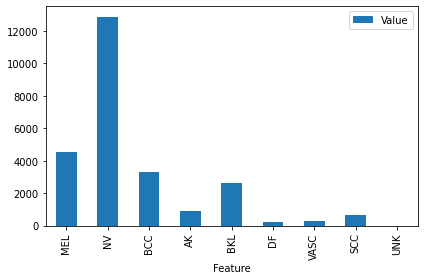

In [ ]:
#sns.countplot(data = train_label, x = 'label')
#plt.title("Train Data label Count")

train_label_AN = train_label.copy(deep='True')
del train_label_AN["image"]
df=pd.DataFrame(train_label_AN.sum(axis=0),columns=['Value'])
df.index.name = 'Feature'
print(df)
df.plot.bar()
plt.tight_layout()
plt.show()

***2. Train Label Percentage Pie Chart***

***Count Distribution of Test Data***

**4. Train Label Percentage Pie Chart**


***5. Printing Images in Different Orientation***

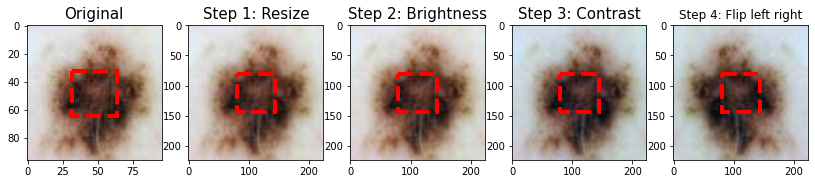

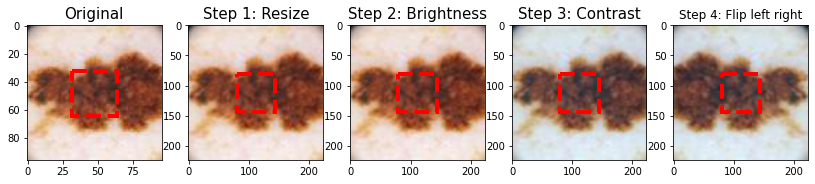

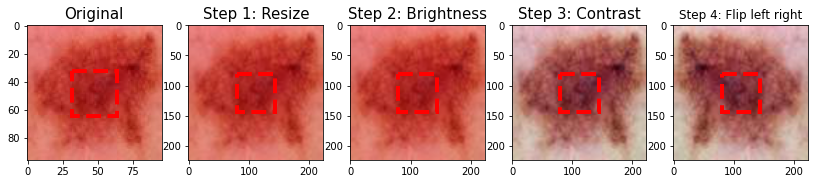

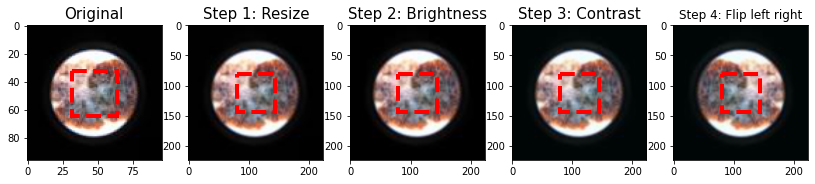

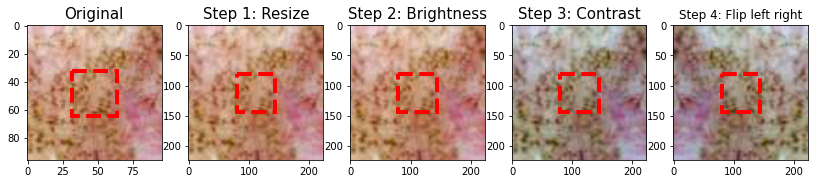

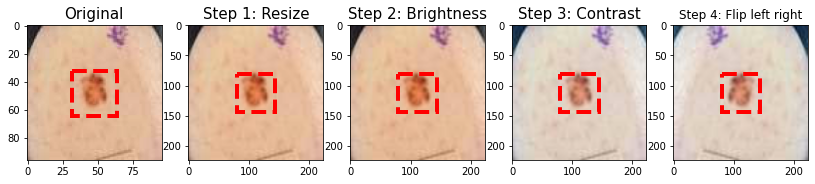

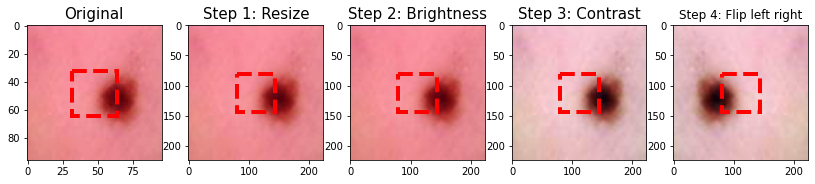

In [ ]:
for image in train_file_list[:7]:
  #print (image)
  misc_proc.print_image_in_diff_orientation(image)

# ***G. Data Preprocessing***

**
1.   Shuffle Data
2.   Create DF with variable values
3.   Get 239 rows of each variable value for equal distribution
4.   Reshuffle the data
5.   Split 80:10:10 
**

In [ ]:
# 1. shuffle and Obtaining split indices
shuffled_train_label = shuffle(train_label)


In [ ]:

list_name = misc_proc.generate_fully_qualified_file_name_list(list(shuffled_train_label),'tiff')
cols = list(shuffled_train_label.columns[1:])
for i in range(0,len(cols)):
      print("Total images of " + cols[i]+ " : "+ str(len(shuffled_train_label[shuffled_train_label[cols[i]]>0])))

label = shuffled_train_label.melt(id_vars =['image'], value_vars =['MEL', 'NV','BCC','AK','BKL','DF','VASC','SCC','UNK'])
label = label.loc[label['value'] == 1.0]
label= label.drop(label.columns[2],axis=1)
label= label.groupby('variable').head(239)

print('DF with variable value')
print('----------------------')

print (label.head(20))

df_groups = label.groupby(['variable'])['variable'].count()
print('Count of each classification')
print('----------------------------')

df_groups

Total images of MEL : 4522
Total images of NV : 12875
Total images of BCC : 3323
Total images of AK : 867
Total images of BKL : 2624
Total images of DF : 239
Total images of VASC : 253
Total images of SCC : 628
Total images of UNK : 0
DF with variable value
----------------------
                        image variable
24               ISIC_0053700      MEL
25               ISIC_0053884      MEL
28               ISIC_0062434      MEL
30               ISIC_0060660      MEL
34               ISIC_0062087      MEL
37               ISIC_0033569      MEL
41               ISIC_0060313      MEL
43               ISIC_0058255      MEL
53               ISIC_0059631      MEL
69               ISIC_0055503      MEL
76               ISIC_0032807      MEL
87               ISIC_0032220      MEL
94               ISIC_0067284      MEL
102              ISIC_0069277      MEL
103              ISIC_0053699      MEL
117              ISIC_0057235      MEL
121  ISIC_0000520_downsampled      MEL
123              

variable
AK      239
BCC     239
BKL     239
DF      239
MEL     239
NV      239
SCC     239
VASC    239
Name: variable, dtype: int64

**Plot showing equal distribution**

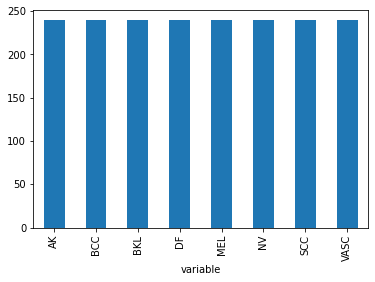

In [ ]:
df_groups = label.groupby(['variable'])['variable'].count()
df_groups.plot(kind='bar')

# **Reshuffle and Split the evenly distributed data into train test and validate**

**Reshuffle the equally ditributed data**

In [ ]:
shuffled_labels = shuffle(label)
print(shuffled_labels)

                           image variable
79868               ISIC_0060157       AK
178480              ISIC_0026132      SCC
103357              ISIC_0026955      BKL
181753              ISIC_0072263      SCC
177500              ISIC_0032329      SCC
...                          ...      ...
77922               ISIC_0024654       AK
25472               ISIC_0029708       NV
25344   ISIC_0006193_downsampled       NV
184581              ISIC_0063363      SCC
102533              ISIC_0030319      BKL

[1912 rows x 2 columns]


**Obtaining Split Indices**

In [ ]:
split_indices = np.multiply(len(shuffled_labels), split).astype(int)
for idx, val in enumerate(split_indices):
    print(idx, val)
    if idx > 0:
        split_indices[idx] = sum(split_indices[idx - 1 : idx]) + split_indices[idx]
print("Split indecs : ", split_indices)

0 1529
1 191
2 191
Split indecs :  [1529 1720 1911]


**Split the data in 80% Train, 10% test, 10% validate**

In [ ]:
(X_train_id, X_val_id, X_test_id) = misc_proc.split_data (split_indices = split_indices,df = shuffled_labels[:split_indices[-1]])
X_train_id


,image,variable
79868,ISIC_0060157,AK
178480,ISIC_0026132,SCC
103357,ISIC_0026955,BKL
181753,ISIC_0072263,SCC
177500,ISIC_0032329,SCC
...,...,...
756,ISIC_0057753,MEL
456,ISIC_0060511,MEL
51907,ISIC_0066495,BCC
101921,ISIC_0055085,BKL


**Generating the fully qualified names**

In [ ]:
X_train_img_file = misc_proc.generate_fully_qualified_file_name_list(list(np.concatenate(X_train_id[['image']].values.tolist()).flat),'.tif')
X_val_img_file = misc_proc.generate_fully_qualified_file_name_list(list(np.concatenate(X_val_id[['image']].values.tolist()).flat),'.tif')
X_test_img_file = misc_proc.generate_fully_qualified_file_name_list(list(np.concatenate(X_test_id[['image']].values.tolist()).flat),'.tif')
print(X_train_img_file)

['/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0060157.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0026132.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0026955.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0072263.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0032329.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0025678.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0027294.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0072970.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0056343.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0026958.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0053457.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0010187.tif', '/content/ISIC_2019_Training_Input/ISIC_2019_Traini

**Reading Image File in Numpy Array**

In [ ]:
X_train_np = img_proc.read_image_file_in_np_array(X_train_img_file)
X_val_np = img_proc.read_image_file_in_np_array(X_val_img_file)
X_test_np = img_proc.read_image_file_in_np_array(X_test_img_file)
print(f"Shape of X_train_np : {X_train_np.shape}")
print(f"Shape of X_val_np : {X_val_np.shape}")
print(f"Shape of X_test_np : {X_test_np.shape}")



Shape of X_train_np : (1529, 96, 96, 3)
Shape of X_val_np : (191, 96, 96, 3)
Shape of X_test_np : (191, 96, 96, 3)


**Converting Numpy Array to Tensor**

In [ ]:
with tf.device('/cpu:0'):
    X_train_tf = img_proc.convert_np_array_to_tensor(X_train_np)
    X_val_tf = img_proc.convert_np_array_to_tensor(X_val_np)
    X_test_tf = img_proc.convert_np_array_to_tensor(X_test_np)


**Converting Images to Grayscale**

In [ ]:
with tf.device('/cpu:0'):
    print("Converting X_train_tf to grayscale ... ")
    X_train_tf = img_proc.convert_to_grayscale(X_train_tf)
    gc.collect()
    tf.keras.backend.clear_session()

    print("Converting X_val_tf to grayscale ... ")
    X_val_tf = img_proc.convert_to_grayscale(X_val_tf)
    gc.collect()
    tf.keras.backend.clear_session()

    print("Converting X_test_tf to grayscale ... ")
    X_test_tf = img_proc.convert_to_grayscale(X_test_tf)
    gc.collect()
    tf.keras.backend.clear_session()

    
    print(f"Shape of X_train_tf after converting to grayscale : {X_train_tf.shape}")
    print(f"Shape of X_val_tf after converting to grayscale : {X_val_tf.shape}")
    print(f"Shape of X_test_tf after converting to grayscale : {X_test_tf.shape}")


Converting X_train_tf to grayscale ... 
Converting X_val_tf to grayscale ... 
Converting X_test_tf to grayscale ... 
Shape of X_train_tf after converting to grayscale : (1529, 96, 96, 1)
Shape of X_val_tf after converting to grayscale : (191, 96, 96, 1)
Shape of X_test_tf after converting to grayscale : (191, 96, 96, 1)


# Model Architecture

**Initiate**

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

**Building the Model**

In [ ]:
#input1 = tf.keras.layers.Input(shape = (96, 96, 1), name = 'Input')
#input2 = tf.keras.layers.Flatten(name = 'Flatten')(input1)
#input3 = tf.keras.layers.Dense(units = 64, activation = 'relu', name = 'fc_1')(input2)
#input4 = tf.keras.layers.Dense(units = 32, activation = 'relu', name = 'fc_2')(input3)
#input5 = tf.keras.layers.Dropout(rate = 0.3, name = 'Dropout')(input4)
#out = tf.keras.layers.Dense(units = 8, activation = 'softmax', name = 'fc_4')(input5)
#model = tf.keras.models.Model(inputs = input1, outputs = out)
#------------------------------------------------------------
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights=None,
                     input_shape=(96,96,1)
                     )
 
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
 
model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])

**Compiling the Model**

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),  
              metrics = [tf.keras.metrics.CategoricalAccuracy()]) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336160  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 1, 1, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

**Fit Model**

In [ ]:
#testing
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )
print (train_files_path)
print ('-----------------')
print (X_train_id) 

def append_ext(fn):
    return fn+".tif"

X_train_gen = X_train_id.copy(deep=True)
X_train_gen['image']= X_train_gen['image'].apply(append_ext)
print ('-----------------------------------------')
print (X_train_gen) 

/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/
-----------------
               image variable
79868   ISIC_0060157       AK
178480  ISIC_0026132      SCC
103357  ISIC_0026955      BKL
181753  ISIC_0072263      SCC
177500  ISIC_0032329      SCC
...              ...      ...
756     ISIC_0057753      MEL
456     ISIC_0060511      MEL
51907   ISIC_0066495      BCC
101921  ISIC_0055085      BKL
79536   ISIC_0063878       AK

[1529 rows x 2 columns]
-----------------------------------------
                   image variable
79868   ISIC_0060157.tif       AK
178480  ISIC_0026132.tif      SCC
103357  ISIC_0026955.tif      BKL
181753  ISIC_0072263.tif      SCC
177500  ISIC_0032329.tif      SCC
...                  ...      ...
756     ISIC_0057753.tif      MEL
456     ISIC_0060511.tif      MEL
51907   ISIC_0066495.tif      BCC
101921  ISIC_0055085.tif      BKL
79536   ISIC_0063878.tif       AK

[1529 rows x 2 columns]


In [ ]:
#testing
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )
train_generator = gen.flow_from_dataframe(
    X_train_gen, # dataframe
    directory = train_files_path, # images data path / folder in which images are there
    x_col = 'image',
    y_col = 'variable',
    subset="training",
    color_mode="grayscale",
    target_size = (96,96), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)
 
 
validation_generator = gen.flow_from_dataframe(
    X_train_gen, # dataframe
    directory = train_files_path, # images data path / folder in which images are there
    x_col = 'image',
    y_col = 'variable',
    subset="validation",
    color_mode="grayscale",
    target_size = (96,96), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)



Found 1224 validated image filenames belonging to 8 classes.
Found 305 validated image filenames belonging to 8 classes.


In [ ]:
x,y = next(train_generator)
x.shape 
train_generator

In [ ]:
batch_size=32
tf.random.set_seed(1234)
np.random.seed(1234)
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 [==============================] - 67s 1s/step - loss: 2.0826 - categorical_accuracy: 0.1124 - val_loss: 2.0818 - val_categorical_accuracy: 0.1181
Epoch 2/25
38/38 [==============================] - 46s 1s/step - loss: 2.0805 - categorical_accuracy: 0.1233 - val_loss: 2.0808 - val_categorical_accuracy: 0.1007
Epoch 3/25
38/38 [==============================] - 50s 1s/step - loss: 2.0785 - categorical_accuracy: 0.1367 - val_loss: 2.0826 - val_categorical_accuracy: 0.1215
Epoch 4/25
38/38 [==============================] - 46s 1s/step - loss: 2.0745 - categorical_accuracy: 0.1460 - val_loss: 2.0766 - val_categorical_accuracy: 0.1285
Epoch 5/25
38/38 [==============================] - 47s 1s/step - loss: 2.0706 - categorical_accuracy: 0.1527 - val_loss: 2.0657 - val_categorical_accuracy: 0.1389
Epoch 6/25
38/38 [==============================] - 47s 1s/step - loss: 2.0546 - categorical_accuracy: 0.1653 - val_loss: 2.0354 - val_categorical_accuracy: 0.1840
Epoch 7/25
38/38 [=========

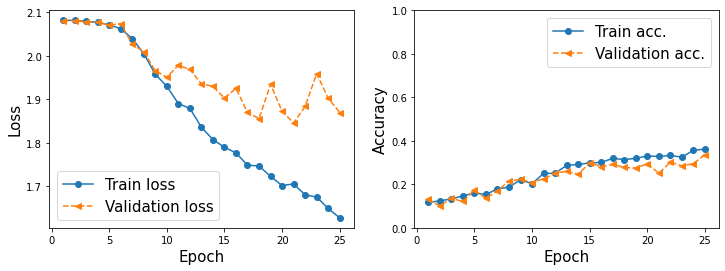

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['categorical_accuracy'], '-o', label = 'Train acc.')
ax.plot(x_arr, hist['val_categorical_accuracy'], '--<', label = 'Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size = 15)
ax.set_ylim(0,1)
plt.show()


**Evaluate the model**

In [ ]:
test_results = model.evaluate( validation_generator)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

10/10 [==============================] - 11s 1s/step - loss: 1.8869 - categorical_accuracy: 0.3246

Test Acc. 32.46%


**Model Prediction**

In [ ]:
train_generator.batch_size
len(train_generator.filenames)
predict=model.predict_generator(train_generator, steps = len(train_generator.filenames))

NameError: ignored

In [ ]:
# transform logits to probabilities
pred_logits = model.predict(train_generator)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

NameError: ignored

**Test vs Prediction**

In [ ]:
# plot test data and associated predicred
#fig = plt.figure(figsize=(20, 20))

#for j, example in enumerate(train_generator[:20]):
#    ax = fig.add_subplot(8, 4, j+1)
#    ax.set_xticks([])
#  ax.set_yticks([])
#    ax.imshow(array_to_img(example))
#    if y_test[j]==0:
#        true_label = 'No Cancer'
#    else:
#        true_label = 'Cancer'
#    
#    ax.text(
#        0.5, -0.15, 
#        'True Label: {:s}\nPr(Cancer)={:.0f}%'.format(true_label, probas[j]), 
#        size = 16, 
#        color = 'grey',
#        horizontalalignment = 'center',
#        verticalalignment = 'center', 
#        transform = ax.transAxes)
#    
#plt.tight_layout()
#plt.show()


TypeError: ignored

<Figure size 1440x1440 with 0 Axes>

In [ ]:
with tf.device('/cpu:0'):
    train_generator_kfold = tf.concat([train_generator] , axis = 0)
    validation_generator_kfold = tf.concat([validation_generator] , axis = 0)

    print("Shuffling the kfold train data...")
    tf.random.set_seed(1234) # for reproducibility
    
    test_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(train_generator_kfold)[0], dtype = tf.int32))
    train_generator_kfold = tf.gather(train_generator_kfold, test_shuffle_indices)
    validation_generator_kfold = tf.gather(validation_generator_kfold, test_shuffle_indices).numpy()

print(f"train_generator_kfold shape: {train_generator_kfold.shape}")
print(f"validation_generator_kfold shape: {validation_generator_kfold.shape}")

NameError: ignored